In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint
import matplotlib.pyplot as plt

In [13]:
# Carregar o CSV
file_path = '/Users/usuario1/Desktop/P_ia/SP500-Prediction-Dimmy/data/sp500.csv'
data = pd.read_csv(file_path)


In [14]:
data['DATE'] = pd.to_datetime(data['DATE'])
data = data.set_index('DATE')

In [15]:
data = data[(data.index >= '2024-04-01') & (data.index <= '2024-06-30')]

In [16]:
if data.empty:
    raise ValueError("Não há dados disponíveis no intervalo especificado.")

In [17]:
data['SP500_shifted'] = data['SP500'].shift(-1)
data.dropna(inplace=True)

In [18]:
X = data[['SP500']]
y = data['SP500_shifted']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regressor = RandomForestRegressor(n_estimators=100, random_state=42)

In [20]:
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_features': ['sqrt', 'log2', None],
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

In [21]:
random_search = RandomizedSearchCV(
    regressor, param_distributions, n_iter=100, cv=5, verbose=1, random_state=42, n_jobs=-1
)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x3036e12e0>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1082b1e80>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x3036e3fb0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1083e8f50>},
                   random_state=42, verbose=1)

In [22]:
losses = []
n_estimators_range = range(10, 201, 10)  # Testando de 10 a 200 árvores, em passos de 10

for n_estimators in n_estimators_range:
    regressor = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    loss = mean_squared_error(y_test, y_pred)
    losses.append(loss)

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(n_estimators_range, losses, marker='o', linestyle='-')
plt.title('Loss (MSE) durante o Treinamento')
plt.xlabel('Número de Árvores (n_estimators)')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

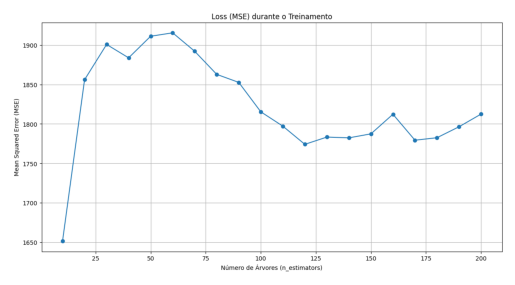

In [3]:
img = plt.imread(r'C:\Users\ednaldo\Desktop\SP500-Prediction-Dimmy\plots\RandomForest\randomforest1.png')
plt.imshow(img) 
plt.axis('off')
plt.show()

In [ ]:
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)

In [ ]:
mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = mean_squared_error(y_test, y_pred_best, squared=False)
r2_best = r2_score(y_test, y_pred_best)

In [ ]:
metrics_best_df = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Score': [mae_best, mse_best, rmse_best, r2_best]
})

print(metrics_best_df)

  Metric        Score
0    MAE    28.057200
1    MSE  1188.894839
2   RMSE    34.480354
3     R²     0.947013

In [ ]:
y_pred_best_series = pd.Series(y_pred_best, index=X_test.index).sort_index()
y_test_sorted = y_test.loc[X_test.index].sort_index()

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_sorted.index, y_test_sorted, label='Valores Reais', color='blue')
plt.plot(y_pred_best_series.index, y_pred_best_series, label='Previsões', color='orange')
plt.legend()
plt.title('Previsões vs Valores Reais - Valores do S&P 500 (Modelo Otimizado)')
plt.xlabel('Data')
plt.ylabel('Valor do S&P 500')
plt.grid(True)
plt.show()

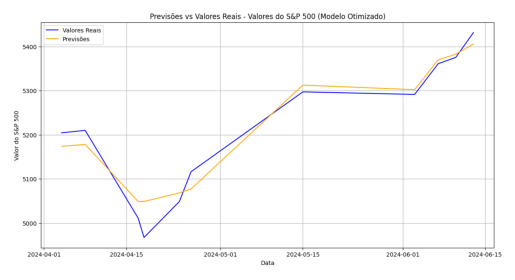

In [4]:
img = plt.imread(r'C:\Users\ednaldo\Desktop\SP500-Prediction-Dimmy\plots\RandomForest\randomforest2.png')
plt.imshow(img) 
plt.axis('off')
plt.show()